Author: Vivek Rawat

Date: 21st March 2021

**Objective:** Predict revenue generated based on PLA click data

**Approach:** This can be formulated as a regression problem to predict revenue based on the PLA data and measure the performance of the model with RMSE.

**Alternate Approach:** Since >99% of the clicks dont generate any revenue, a direct regression approach will be biased towards zero revenue instances. So, this problem can be framed in two steps:

          1. Sales prediction: Binary classification to predict sales 
                              occurance of sales (based on non zero revenue)
                              1 - Sale occured
                              0 - No Sale
          2. Revenue prediction: If sale occured, predict the value with Regression

**Performance Evaluation:** 

For the direct regression approach model can be evaluated with RMSE scores on cross validation folds.

For the alternate approach mentioned above:

                        1. Sales prediction: Objective here is to filter the instances
                                            for the regression task. So it is critical to
                                            minimise False Negatives, whereas False positives
                                            are tolerable. So we need to maximise the Recall
                                            as much as possible.
                        2. Revenue prediction: This is a regression task and RMSE can be used
                                              as the performance metric




#Observations on features

**'day_id':** Can be transformed to day of the week, which might better correlate to the sales behaviour

**'net_price':** Numerical feature with skewed distribution and outliers: 
              Applying log transformation

**'num1':** binary feature

**'num2':** numerical feature with an outlier (high correlation with 'num6')

**'num3':** numerical feature (high correlation with 'num6')

**'num4':** numerical feature, very large range;

**'num5':** numerical feature, skewed, outliers; applying log transformation

**'num6':** numerical feature

**'cat1':** categorical; very high cardinality;
        This is most likely a product identifier since the net_price within each category is mostly a unique value (~60% of instances). So this ID can be used to create a price variation feature for the model, using % price variation compared to the most frequent price of the product.

**'cat2':** categorical; high cardinality; using hash encoder

**'cat3':** categorical; high cardinality; using hash encoder

#Created Features

**'dow':** Day of the week, created from day_id

**'price_var':** %variation of net_price above or below the mode within each category of cat1. This should encode discount information or any price hike.



#Target

'net_revenue': >99% zeroes; skewed distribution; log transfomation should help

##Discussion

Direct regression approach did not yield accurate predictions for higher revenue instances because the training data is unbalanced with a >99% zero revenue instances. Model is underpredicting the revenue in for instances with high revenue.

This can possibly be further improved with exploring the features better and trying other regression models. A better understanding of the anonymized numerical features will certainly help. Also looking at feature importance values would allow for better feature selection.

For high cadinality categorical features, simple one hot encoding would be memory and time prohibitive so I explored the following:

 - cat1 is mostly likely a product ID so price variation within each ID is used as a feature istead of cat1.
 - cat2 and cat3 have a one to many relationship with cat1 so they could be a part of product hierarchy. These also have high cardinality so a hashing encoder was used to limit the no of columns. This could have possibility of collisions which should be further explored based on number of features.
 - For hashing encoder 'n_components' parameter was optimized grid search.

Futher improvements::

- Build a better understanding of the anonymized features to leverage them better. This would allow for creating new features that could be useful.
- Understanding the product hierarchy (possibly cat2 and cat3 features) will help in building separate models for each class of product if required.
- Further experimentation with encoding of categorical features; features in these categories could be created from net_revenue (by aggregation etc) but overfitting could be an issue here.
- In the two step approach mentioned above, further improvements are required to achieve a better recall value of the classifier and then try other regression approaches to predict revenue for instances where sale is predicted.
- Gradient boosting models should be explored in both the approaches mentioned.
- The log transformations attempted for features and target variable must be tested further.

In [317]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix


%matplotlib inline

#file paths
train_file_path = 'Documents/DS_Projects/Code Challenge/'
test_file_path = 'Documents/DS_Projects/Code Challenge/'

train_data = pd.read_csv(train_file_path + 'train_data.csv')
test_data = pd.read_csv(test_file_path + 'test_data.csv')


In [281]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169181 entries, 0 to 169180
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   net_price          169181 non-null  float64
 1   day_id             169181 non-null  int64  
 2   num1               169181 non-null  int64  
 3   num2               169181 non-null  float64
 4   num3               169181 non-null  float64
 5   num4               169181 non-null  float64
 6   num5               169181 non-null  float64
 7   num6               169181 non-null  int64  
 8   cat1               169181 non-null  object 
 9   cat2               169181 non-null  object 
 10  cat3               169181 non-null  object 
 11  net_revenue        169181 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 15.5+ MB


In [282]:
train_data.describe()

,net_price,day_id,num1,num2,num3,num4,num5,num6,net_revenue
count,169181.000000,1.691810e+05,169181.000000,169181.000000,169181.000000,169181.000000,169181.000000,169181.000000,169181.000000
mean,153.063780,2.015115e+07,0.205472,1.086697,0.981035,159.726163,2.420819,8.829614,1.047490
std,242.471639,4.919680e+01,0.404047,0.103898,0.080651,3260.382188,6.967517,3.708434,16.636636
min,0.040000,2.015110e+07,0.000000,0.520000,0.290000,0.000000,0.000029,1.000000,0.000000
25%,30.500000,2.015112e+07,0.000000,1.020000,0.930000,24.000000,0.358512,6.000000,0.000000
50%,88.460000,2.015112e+07,0.000000,1.060000,0.960000,96.000000,0.936000,9.000000,0.000000
75%,187.780000,2.015120e+07,0.000000,1.130000,1.010000,192.000000,2.454249,11.000000,0.000000
max,24927.500000,2.015123e+07,1.000000,11.680000,2.410000,402528.000000,1148.680000,35.000000,1611.630252


In [318]:
#Clean the col names

train_data.columns = [col.strip() for col in train_data.columns]
train_data.columns

test_data.columns = [col.strip() for col in test_data.columns]
test_data.columns

Index(['net_price', 'day_id', 'num1', 'num2', 'num3', 'num4', 'num5', 'num6',
       'cat1', 'cat2', 'cat3'],
      dtype='object')

In [284]:
#Analysing categorical features

print(train_data[['cat1', 'cat2', 'cat3']].nunique())

df = train_data.groupby('cat1').agg({'net_price': 'nunique'}).reset_index()
print(df[df.net_price>4].count()/df.count())

# df.plot(x='cat1', y='net_price')
# df.plot(x='cat1', y='net_revenue')

cat1    16794
cat2      652
cat3     1975
dtype: int64
cat1         0.003156
net_price    0.003156
dtype: float64


In [285]:
#Analysing categorical features

df = train_data.groupby('cat1').agg({'cat2': 'nunique'}).reset_index()
print(df[df.cat2>1].count()/df.count())

df = train_data.groupby('cat1').agg({'cat3': 'nunique'}).reset_index()
print(df[df.cat3>1].count()/df.count())

cat1    0.0
cat2    0.0
dtype: float64
cat1    0.0
cat3    0.0
dtype: float64


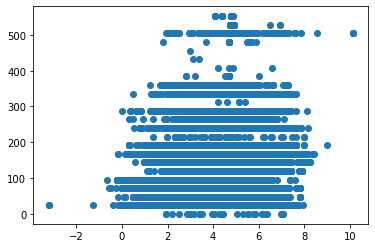

In [286]:
plt.scatter(np.log(train_data[train_data.num4<600]['net_price']),
                          (train_data[train_data.num4<600]['num4']))

In [287]:
# plt.scatter((train_data[train_data.num4<600]['day_id']),
                          # (train_data[train_data.num4<600]['num4']))

df = train_data.copy()
df['day_id'] = pd.to_datetime(df['day_id'], format='%Y%m%d')
df['doy'] = df['day_id'].dt.dayofyear

df['price_var'] = df.groupby('cat1')['net_price']\
                                  .transform(lambda x: (1-x/x.mode().values[0]))

# [train_data.num4<600]

#Checking for multicollinearity in numerical features

In [288]:
#Computing VIFs for all features

def check_multiCollinearity(df):

    #Cal variance inflation factor
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

vif = check_multiCollinearity(df[['num1', 'num3', 'num6', 'num4', 'num5', 
                                  'net_price', 'net_revenue', 'price_var']])
vif

,variables,VIF
0,num1,1.255517
1,num3,7.171991
2,num6,6.683893
3,num4,1.002693
4,num5,1.251579
5,net_price,1.557684
6,net_revenue,1.003946
7,price_var,1.001651


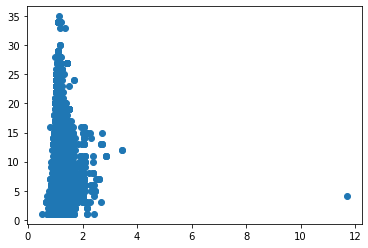

In [289]:
plt.scatter(df['num2'], df['num6'])

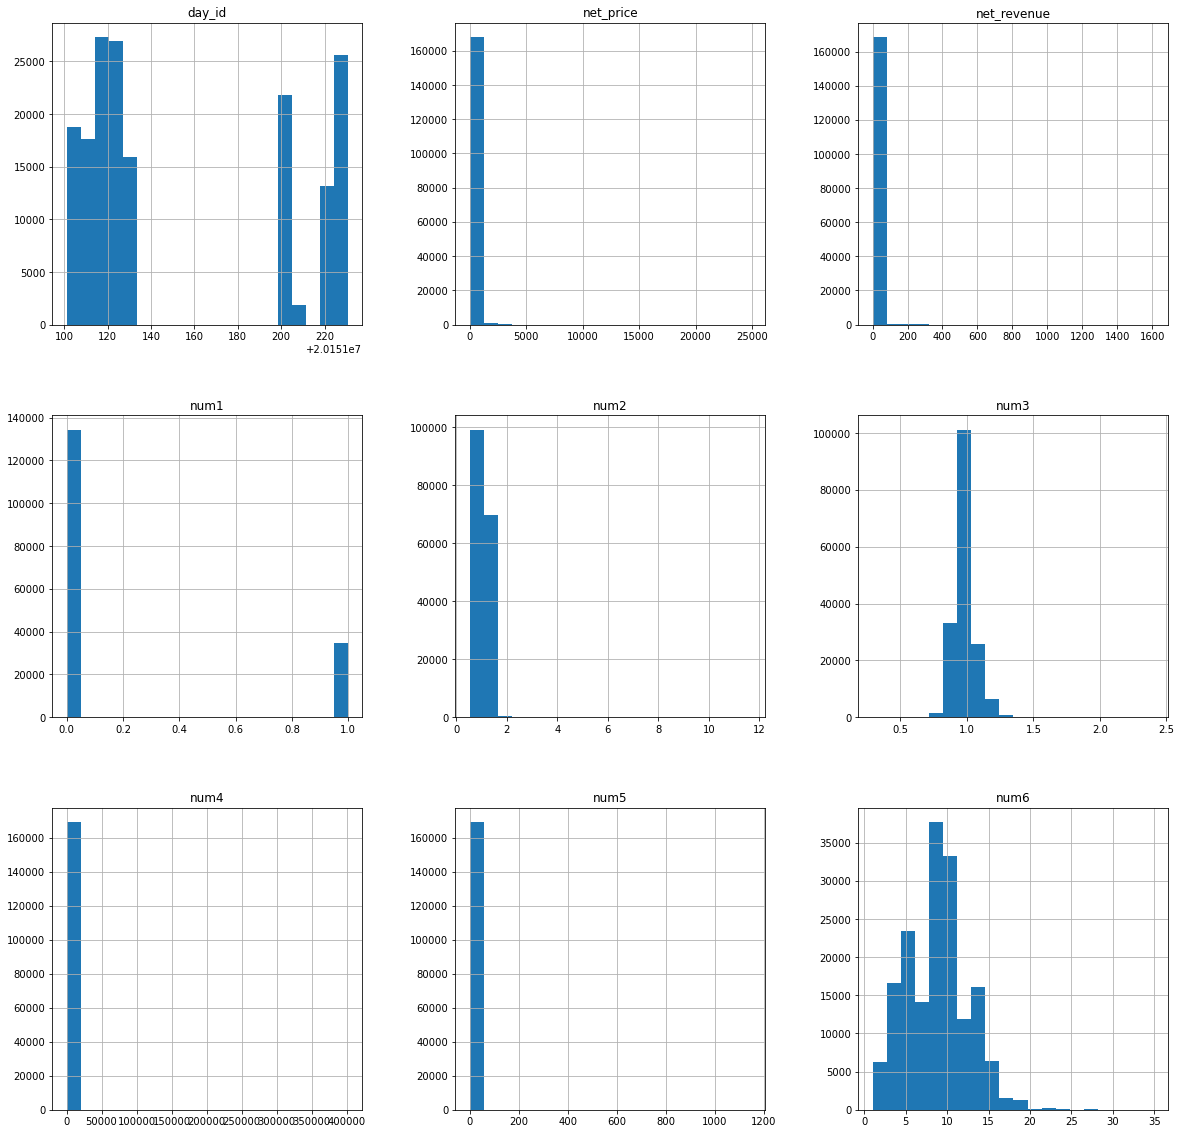

In [290]:
#Create histogram from numerical variables

train_data.hist(bins=20, figsize=(20, 20))
plt.show()

(0.001, 10.0)

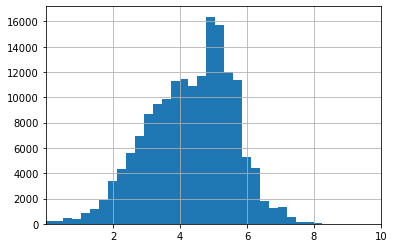

In [291]:
np.log(train_data['net_price']).hist(bins=50)
plt.xlim(0.001, 10)

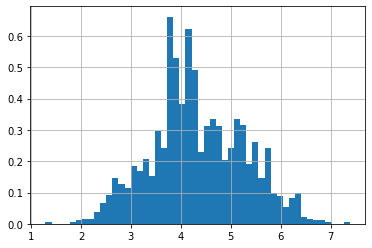

In [292]:
np.log(train_data[train_data.net_revenue>0.01]['net_revenue']+0.00001).hist(bins=50, density=True)
# plt.xlim(0.001, 200)

In [319]:
#Create new features as describe above

train_x = train_data.drop(['net_revenue'], axis=1)
train_y = train_data['net_revenue'].copy()

train_clf_y = np.where(train_data['net_revenue']>0, 1, 0)
# train_data['net_revenue'].apply(lambda x: 1 if x>0 else 0)

#Converting day_id to day of the week

train_x['day_id'] = pd.to_datetime(train_x['day_id'], format='%Y%m%d')
train_x['dow'] = train_x['day_id'].dt.day_name()

test_data['day_id'] = pd.to_datetime(test_data['day_id'], format='%Y%m%d')
test_data['dow'] = test_data['day_id'].dt.day_name()

#Price variation in cat1

train_x['price_var'] = train_x.groupby('cat1')['net_price']\
                                  .transform(lambda x: (1-x/x.mode().values[0]))

test_data['price_var'] = test_data.groupby('cat1')['net_price']\
                                  .transform(lambda x: (1-x/x.mode().values[0]))                                  

#Numerical features

#num2 and num3 are highly correlated with num6, so dropping num2 and num3
num_ft = ['net_price', 'num1', 'num4', 'num5', 'num6', 'price_var']

#log transform features
log_ft = ['net_price', 'num5']

#cat is encoded as 'price_var' so dropped here
ohe_ft = ['dow']
hash_ft = ['cat2', 'cat3']


#Pipeline to prepare numerical and categorical features

In [315]:
num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('scaler', StandardScaler())
                        ])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('hashing', ce.hashing.HashingEncoder()) #Hashing encoder for high cardinality features
    ])
    
feature_process = ColumnTransformer([
        ('num', num_pipeline, num_ft),
        ('log', FunctionTransformer(np.log), log_ft),
        ('cat', cat_pipeline, hash_ft),
        ('ohe', OneHotEncoder(), ohe_ft)
        ])
    
full_pipeline = Pipeline([('feature_process', feature_process),
                 ('rf', RandomForestRegressor(random_state=123))])

#Transformed features
X = feature_process.fit_transform(train_x)
y = np.log(train_y + 0.000001)

#Direct regression approach

Grid search on pipeline parameters and RandomForestRegressor

In [310]:
param_grid = [
              {'rf__n_estimators': [200, 300, 400], 
               'rf__max_features': [8, 10],
               'feature_process__cat__hashing__n_components': [10, 30]
               }
              ]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True, n_jobs=-1, verbose=3)

grid_search.fit(train_x, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['net_price',
                                                                          'num1',
                                                                          'num4',
                                                                          'num5',
                                                                        

In [311]:
grid_search.best_params_

{'feature_process__cat__hashing__n_components': 10,
 'rf__max_features': 8,
 'rf__n_estimators': 200}

#Performance evaluation on a random split validation set

In [328]:
grid_search.best_estimator_[1]

RandomForestRegressor(max_features=8, n_estimators=200, random_state=123)

In [348]:
#Create the random split for validation

_, val_x, _, val_y = train_test_split(train_x, y, test_size=0.2, random_state=123)


#Prediction with best estimator

val_x_prep = grid_search.best_estimator_[0].transform(val_x)
model = grid_search.best_estimator_[1]

pred = model.predict(val_x_prep)

val_mse = mean_squared_error(val_y, pred)
val_rmse = np.sqrt(val_mse)
print("RMSE for revenue prediction::", val_rmse)


RMSE for revenue prediction:: 1.2804136805848636


#Prediction on test set

In [350]:
#Prediction with best estimator from the grid search

test_x_prep = grid_search.best_estimator_[0].transform(test_data)
model = grid_search.best_estimator_[1]

final_pred = model.predict(test_x_prep)

In [357]:
len(test_data)

97486

In [358]:
len(final_pred)

97486

In [364]:
final_pred_tr = pd.DataFrame(np.exp(final_pred), columns=['revenue_prediction'])

test_output = pd.concat([test_data, final_pred_tr], axis=1)
test_output.head()

test_output.to_csv('Documents/DS_Projects/PLAclick_revenue_out.csv')

In [359]:
final_pred_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97486 entries, 0 to 97485
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   revenue_prediction  97486 non-null  float64
dtypes: float64(1)
memory usage: 761.7 KB


#Alternative approach attempted below but not completed

#Classification for sales/No sales


In [ ]:
full_pipeline = Pipeline([('feature_process', feature_process),
                 ('clf', LogisticRegression())])

grid_params = {
          'feature_process__cat__hashing__n_components': [5],#, 10, 30],
          'clf__penalty': ['l2'],
          'clf__solver': ['lbfgs'],#, 'newton-cg', 'liblinear'],
          'clf__C': [0.0001, 0.001, 0.01]
          }

grid_search = GridSearchCV(full_pipeline, grid_params, cv=5,
                           scoring='f1', verbose=2, n_jobs=-1)
grid_search.fit(train_x, train_clf_y)

In [183]:
grid_search.best_params_

{'clf__C': 0.0001,
 'clf__penalty': 'l2',
 'clf__solver': 'lbfgs',
 'feature_process__cat__hashing__n_components': 5}

In [184]:
results = grid_search.cv_results_
results


{'mean_fit_time': array([0.71424403, 0.82168345, 0.84228492]),
 'std_fit_time': array([0.01117106, 0.06249077, 0.03429017]),
 'mean_score_time': array([0., 0., 0.]),
 'std_score_time': array([0., 0., 0.]),
 'param_clf__C': masked_array(data=[0.0001, 0.001, 0.01],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__penalty': masked_array(data=['l2', 'l2', 'l2'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__solver': masked_array(data=['lbfgs', 'lbfgs', 'lbfgs'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_feature_process__cat__hashing__n_components': masked_array(data=[5, 5, 5],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__C': 0.0001,
   'clf__penalty': 'l2',
   'clf__solver': 'lbfgs',
   'feature_process__cat__hashing__n_components': 5},
  {'clf__C

In [246]:
X.shape

(169181, 8)

In [247]:
lr = LogisticRegression()

In [248]:
cross_val_score(lr, X, train_clf_y, cv=3, scoring='f1', verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.000, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=0.000, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] .................................... , score=0.000, total=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished


array([0., 0., 0.])

In [249]:
y_pred = cross_val_predict(lr, X, train_clf_y, cv=3)


In [253]:
recall_score(train_clf_y, y_pred)

0.0

In [229]:
pred = np.c_[y_pred, train_clf_y]

len(pred[(pred==[1, 1]) | (pred==[0,0])])

338362

In [255]:
a = y_pred + train_clf_y
len(a[a==2])

0

In [269]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 140}

In [271]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
  print(np.sqrt(-mean_score), params)

17.45939363891985 {'max_features': 8, 'n_estimators': 100}
17.43380208101577 {'max_features': 8, 'n_estimators': 120}
17.426406755089893 {'max_features': 8, 'n_estimators': 140}


#Regression to predict revenue where sales is predicted

In [ ]:
#target variable for the second step (sales predicted)

y_sales = pred_clf[pred_clf==1]

In [277]:
#Support Vector Regressor

svm_reg = SVR(kernel='linear')
svm_reg.fit(X, y_sales)

pred = svm_reg.predict(X)
svm_mse = mean_squared_error(y_sales, pred)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

16.663549498162652